In [ ]:
print("hola mundo")

hola mundo


## **Importaci√≥n de bibliotecas**

A continuaci√≥n, se describen las bibliotecas utilizadas en el desarrollo del modelo:

- **os**: Permite interactuar con el sistema operativo, √∫til para manejar archivos y directorios en la carga de datos.
- **torch**: Librer√≠a principal de PyTorch para el desarrollo y entrenamiento de modelos de aprendizaje profundo.
- **torch.nn**: Proporciona m√≥dulos y funciones para construir redes neuronales en PyTorch.
- **torch.optim**: Contiene optimizadores utilizados para entrenar modelos mediante descenso de gradiente.
- **pandas**: Se utiliza para manipulaci√≥n y an√°lisis de datos tabulares, como la carga de etiquetas desde archivos CSV.
- **torchvision.transforms**: Ofrece transformaciones para preprocesar im√°genes antes de ingresarlas al modelo.
- **PIL (Python Imaging Library)**: Se usa para cargar y manipular im√°genes en diferentes formatos.
- **torch.utils.data (Dataset y DataLoader)**: Facilita la gesti√≥n de los conjuntos de datos y su alimentaci√≥n al modelo en lotes.
- **itertools**: Proporciona herramientas para iteraciones eficientes, √∫til para combinaciones o permutaciones de datos.
- **torchvision.models (efficientnet_v2_s)**: Se importa el modelo preentrenado EfficientNetV2-S, que se usar√° como base para la clasificaci√≥n.
- **torch.nn.functional**: Contiene funciones √∫tiles como activaciones, p√©rdidas y operaciones sobre tensores.

### **Uso en el notebook**
Estas bibliotecas permiten construir un pipeline de aprendizaje profundo que incluye:
1. **Carga y preprocesamiento de datos**: Se usa `os`, `pandas`, `PIL`, y `torchvision.transforms` para leer im√°genes y etiquetas.
2. **Definici√≥n del modelo**: Se emplea `torch.nn` y `efficientnet_v2_s` para crear la red neuronal.
3. **Entrenamiento**: `torch.optim` y `torch.nn.functional` ayudan a definir el proceso de optimizaci√≥n y la funci√≥n de p√©rdida.
4. **Evaluaci√≥n y predicci√≥n**: Se aplican las herramientas de PyTorch para evaluar el modelo y generar predicciones sobre datos de prueba.

---


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import itertools
from torchvision.models import efficientnet_v2_s
import torch.nn.functional as F

## **Carga y organizaci√≥n de datos**

En esta secci√≥n, organizamos los conjuntos de datos para entrenamiento, validaci√≥n y prueba.  
Los datos provienen del desaf√≠o **BreastPathQ 2019** y est√°n estructurados en im√°genes de parches histol√≥gicos junto con sus etiquetas.

### **1Ô∏è Directorios de im√°genes**
- **`train_image_dir`**: Contiene las im√°genes de entrenamiento con sus etiquetas.
- **`val_image_dir`**: Contiene las im√°genes de validaci√≥n con sus etiquetas.
- **`test_image_dir`**: Contiene las im√°genes de prueba (sin etiquetas).

### **2Ô∏è Rutas de etiquetas**
- **`train_label_path`**: Archivo CSV con etiquetas de entrenamiento.
- **`val_label_path`**: Archivo CSV con etiquetas de validaci√≥n.

---

## **Procesamiento de los conjuntos de datos**

1. **Entrenamiento (`df_train`)**
   - Se carga el CSV de entrenamiento.
   - Se genera el nombre de cada imagen combinando `slide` y `rid`.
  
2. **Validaci√≥n (`df_val`)**
   - Se listan todas las im√°genes del directorio de validaci√≥n.
   - Se extrae el `slide` y `rid` del nombre del archivo.
   - Se unen estos datos con el CSV de etiquetas.

3. **Prueba (`df_test`)**
   - Se listan todas las im√°genes del directorio de prueba.
   - Se extrae el `slide` y `rid` del nombre del archivo.
   - **(Importante)** No hay etiquetas en este conjunto.

---

## **Diagrama de distribuci√≥n de imagenes en los conjuntos de datos**
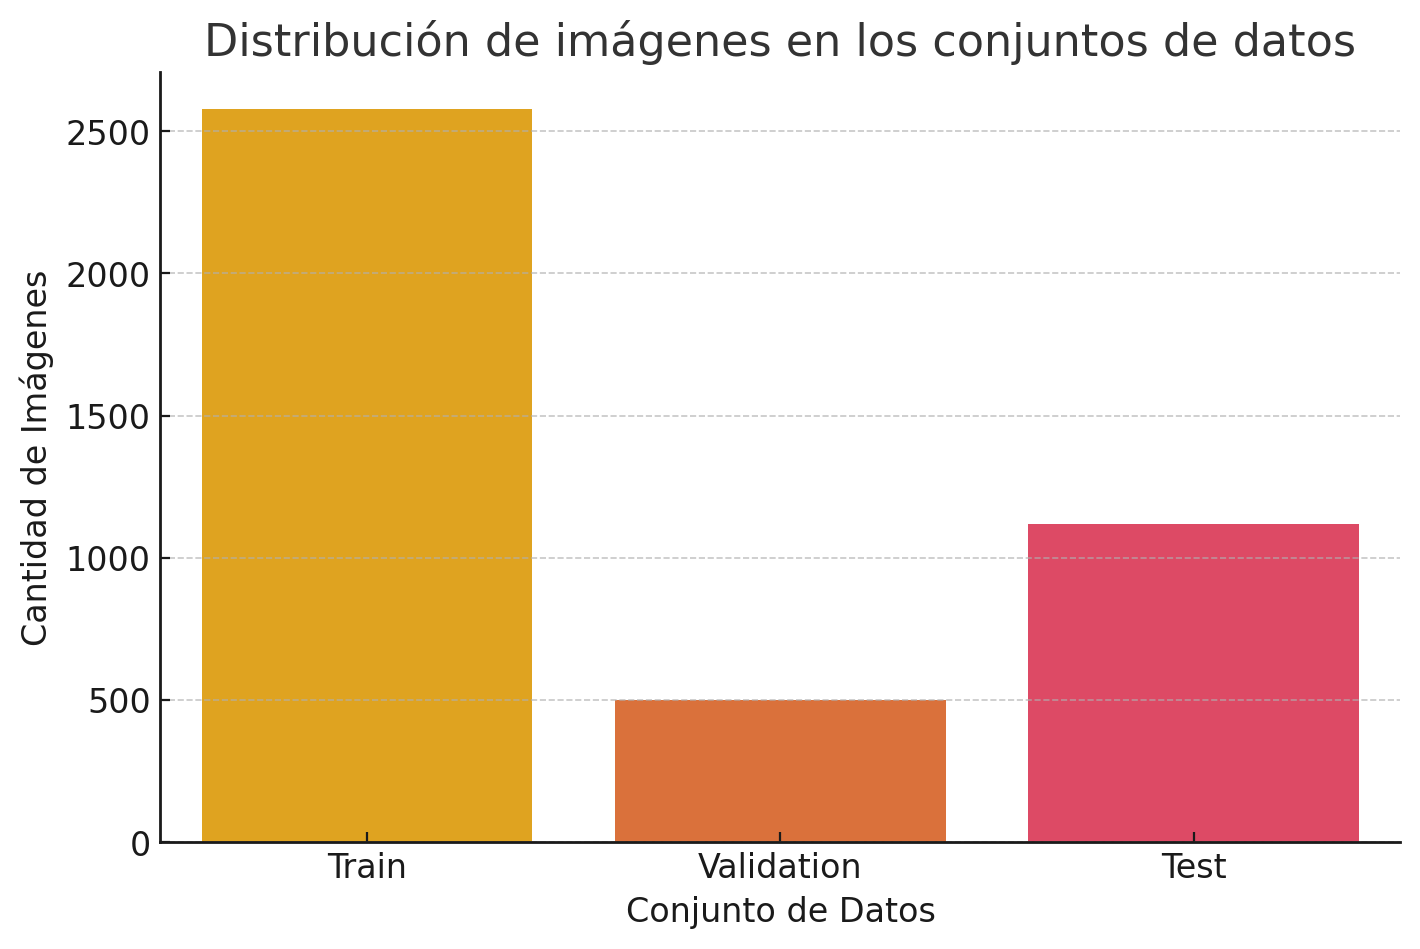


---


In [ ]:
# Directorios de im√°genes
train_image_dir = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/train"
val_image_dir = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/validation"
test_image_dir = "datasets/SPIE_BreastPathQ2019_Testing/breastpathq-test/test_patches"

# Rutas de etiquetas
train_label_path = "datasets/SPIE_BreastPathQ2019_Training_Validation/breastpathq/datasets/train_labels.csv"
val_label_path = "datasets/SPIE_BreastPathQ2019_Testing/breastpathq-test/val_labels.csv"

# Cargar datos
df_train = pd.read_csv(train_label_path)
df_train["image_name"] = df_train["slide"].astype(str) + "_" + df_train["rid"].astype(str) + ".tif"

val_images = [f for f in os.listdir(val_image_dir) if f.endswith(".tif")]
df_val = pd.DataFrame({"image_name": val_images})
df_val[["slide", "rid"]] = df_val["image_name"].str.extract(r'(\d+)_(\d+).tif').astype(int)
df_val_labels = pd.read_csv(val_label_path)
df_val = df_val.merge(df_val_labels, on=["slide", "rid"], how="left")

test_images = [f for f in os.listdir(test_image_dir) if f.endswith(".tif")]
df_test = pd.DataFrame({"image_name": test_images})
df_test[["slide", "rid"]] = df_test["image_name"].str.extract(r'(\d+)_(\d+).tif').astype(int)

# Resumen de conjuntos de datos
print("Organizaci√≥n Final de Conjuntos:")
print(f"Train: {len(df_train)} im√°genes")
print(f"Validation: {len(df_val)} im√°genes")
print(f"Test_patches: {len(df_test)} im√°genes (Debe ser 1119)")


Organizaci√≥n Final de Conjuntos:
Train: 2394 im√°genes
Validation: 185 im√°genes
Test_patches: 1119 im√°genes (Debe ser 1119)


## **Exploraci√≥n de Datos y Transformaci√≥n de Im√°genes**

En esta secci√≥n, se define la clase `BreastDataset`, que nos permite organizar y acceder a las im√°genes del dataset de c√°ncer de mama. Adem√°s, se aplican transformaciones a las im√°genes para normalizarlas y adaptarlas al modelo de clasificaci√≥n.

### **Definici√≥n de la Clase `BreastDataset`**

Esta clase hereda de `torch.utils.data.Dataset` y tiene los siguientes m√©todos:

- **`__init__(self, df, image_dir, transform=None, is_test=False)`**:  
  - Recibe un DataFrame con la informaci√≥n de las im√°genes (`df`).
  - Recibe la ruta donde est√°n almacenadas las im√°genes (`image_dir`).
  - Opcionalmente, recibe una transformaci√≥n (`transform`) que se aplicar√° a las im√°genes antes de ingresarlas al modelo.
  - El par√°metro `is_test` indica si el dataset pertenece al conjunto de prueba (sin etiquetas).

- **`__len__(self)`**:  
  - Devuelve la cantidad de im√°genes en el dataset.

- **`__getitem__(self, idx)`**:  
  - Carga una imagen espec√≠fica basada en su √≠ndice `idx`.
  - Aplica las transformaciones definidas si est√°n presentes.
  - Si `is_test=True`, devuelve solo la imagen y su nombre (sin etiqueta).  
  - En caso contrario, devuelve la imagen junto con su etiqueta (`y`).

---

### **Transformaciones aplicadas a las im√°genes**

Se define una serie de transformaciones en la variable `transform`, utilizando `torchvision.transforms`:

1. **Redimensionado**:  
   - `transforms.Resize((300, 300))`: Escala todas las im√°genes a 300x300 p√≠xeles para que el modelo las procese correctamente.
   
2. **Conversi√≥n a tensor**:  
   - `transforms.ToTensor()`: Convierte la imagen a un tensor, necesario para PyTorch.
   
3. **Normalizaci√≥n**:  
   - `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Ajusta los valores de los p√≠xeles para que el modelo preentrenado (EfficientNetV2) los procese mejor.

---

### **Valores de normalizaci√≥n basados en ImageNet**

Estos valores no son elegidos al azar. Se basan en las estad√≠sticas de las im√°genes del conjunto de datos ImageNet, un dataset masivo utilizado para entrenar muchos modelos de visi√≥n artificial, incluyendo EfficientNetV2.

1. **¬øQu√© significan estos valores?**

   - **mean=[0.485, 0.456, 0.406]**: Son los valores promedio (media) de los canales Rojo (R), Verde (G) y Azul (B) en todas las im√°genes de ImageNet.
   - **std=[0.229, 0.224, 0.225]**: Representan la desviaci√≥n est√°ndar de cada canal en el conjunto de ImageNet.

2. **¬øPor qu√© se normalizan las im√°genes con estos valores?**

   Los modelos preentrenados como EfficientNetV2 han sido entrenados con im√°genes que ya estaban normalizadas con estos valores de ImageNet. Cuando usamos este modelo para nuestro problema, queremos que las im√°genes de nuestro dataset tengan una distribuci√≥n de p√≠xeles similar a la de las im√°genes con las que EfficientNetV2 fue entrenado. Esto tiene varios beneficios:

   - **Compatibilidad con el modelo**: EfficientNetV2 fue entrenado esperando im√°genes con esta normalizaci√≥n, por lo que al usar los mismos valores, aseguramos que nuestro modelo procese los datos correctamente.
   - **Asegurar que las im√°genes tengan una escala uniforme**: Sin normalizaci√≥n, los valores de los p√≠xeles de las im√°genes originales pueden estar entre 0 y 255 (escala RGB), lo que podr√≠a generar problemas num√©ricos al entrenar una red neuronal. Al normalizar, los valores se transforman a una distribuci√≥n con media cercana a 0 y varianza cercana a 1, lo que ayuda a estabilizar el entrenamiento.
   - **Facilitar la convergencia del modelo**: Al normalizar, evitamos que algunos canales dominen sobre otros, reduciendo el riesgo de que el modelo aprenda patrones sesgados debido a diferencias en escala entre los valores de p√≠xeles.

3. **¬øQu√© pasa si no normalizamos?**

   Si no aplicamos esta normalizaci√≥n:

   - Los valores de los p√≠xeles seguir√≠an en el rango [0, 255] o [0, 1] (si solo usamos `ToTensor()`), lo que har√≠a que el modelo tenga dificultades para hacer predicciones precisas.
   - La red podr√≠a tardar m√°s en aprender, porque tendr√≠a que ajustarse a datos con una escala diferente a la que us√≥ en su entrenamiento inicial.
   - En algunos casos, el modelo podr√≠a dar resultados inconsistentes o con menor precisi√≥n.

4. **¬øC√≥mo afecta visualmente la imagen transformada?**

   En la imagen transformada:

   - Vemos un aumento del contraste, lo que hace que las estructuras celulares sean m√°s evidentes.
   - Los tonos pueden parecer m√°s saturados o distintos, ya que la normalizaci√≥n ajusta los valores de los p√≠xeles en funci√≥n de la distribuci√≥n esperada por el modelo.

---

In [ ]:
class BreastDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, is_test=False):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["image_name"]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_test:
            return image, img_name
        else:
            label = self.df.iloc[idx]["y"]
            return image, torch.tensor(label, dtype=torch.float32)

# Transformaciones para EfficientNetV2
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets y dataloaders
train_dataset = BreastDataset(df_train, train_image_dir, transform)
val_dataset = BreastDataset(df_val, val_image_dir, transform)
test_dataset = BreastDataset(df_test, test_image_dir, transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


## **Comparaci√≥n de Im√°genes: Original vs Transformada**

En esta secci√≥n, se selecciona una imagen aleatoria del conjunto de entrenamiento para visualizar c√≥mo se ve antes y despu√©s de aplicar las transformaciones definidas. Esto nos permite entender el impacto de las transformaciones en la imagen y c√≥mo se preparan los datos para el modelo.

### **Proceso de Comparaci√≥n**

1. **Selecci√≥n de una imagen aleatoria**:  
   - Se elige un √≠ndice aleatorio dentro del dataset de entrenamiento utilizando `random.randint`.
   - Este √≠ndice se utiliza para obtener la imagen transformada y su etiqueta correspondiente.

2. **Carga de la imagen original**:  
   - Se obtiene la ruta de la imagen original utilizando el nombre de la imagen almacenado en el DataFrame.
   - La imagen original se carga utilizando `PIL.Image.open` y se convierte al formato RGB.

3. **Visualizaci√≥n de ambas im√°genes**:  
   - Se crea una figura con dos subplots para mostrar la imagen original y la imagen transformada lado a lado.
   - La imagen transformada se convierte de un tensor (formato utilizado por PyTorch) a un formato RGB para su visualizaci√≥n.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781512..2.64].


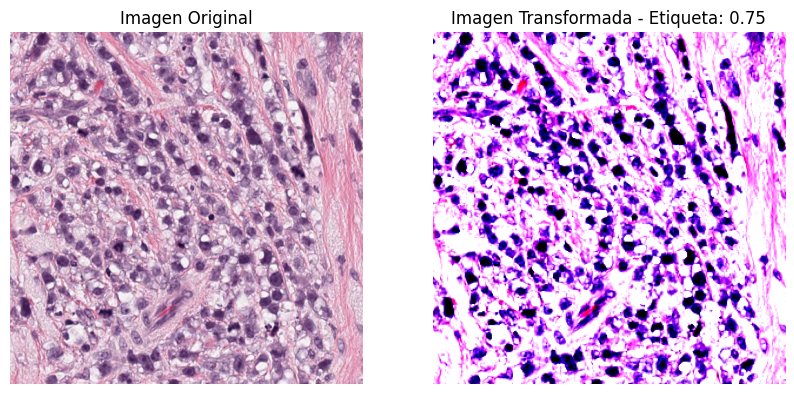

In [73]:

# Seleccionar un √≠ndice aleatorio dentro del dataset de entrenamiento
random_idx = random.randint(0, len(train_dataset) - 1)

# Obtener la imagen transformada y su etiqueta
image_transformed, label = train_dataset[random_idx]

# Obtener la ruta de la imagen original
img_name = train_dataset.df.iloc[random_idx]["image_name"]
img_path = os.path.join(train_dataset.image_dir, img_name)

# Cargar la imagen original
image_original = Image.open(img_path).convert("RGB")

# Mostrar ambas im√°genes: original y transformada
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
axes[0].imshow(image_original)
axes[0].set_title("Imagen Original")
axes[0].axis("off")

# Imagen transformada
axes[1].imshow(image_transformed.permute(1, 2, 0))  # Convertir tensor a imagen RGB
axes[1].set_title(f"Imagen Transformada - Etiqueta: {label.item()}")
axes[1].axis("off")

plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"üìå Dispositivo en uso: {device}")

efficientnet = efficientnet_v2_s(weights="IMAGENET1K_V1")
num_ftrs = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_ftrs, 1)  # Modificar la capa final para regresi√≥n
efficientnet = efficientnet.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(efficientnet.parameters(), lr=0.0008)


üìå Dispositivo en uso: cuda


In [ ]:
epochs = 50  # Ajustamos a 50 ya que EfficientNetV2 aprende m√°s r√°pido
for epoch in range(epochs):
    efficientnet.train()
    epoch_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"üìå √âpoca {epoch+1}/{epochs} - P√©rdida: {epoch_loss/len(train_loader):.4f}")


üìå √âpoca 1/50 - P√©rdida: 0.0424
üìå √âpoca 2/50 - P√©rdida: 0.0176
üìå √âpoca 3/50 - P√©rdida: 0.0123
üìå √âpoca 4/50 - P√©rdida: 0.0099
üìå √âpoca 5/50 - P√©rdida: 0.0085
üìå √âpoca 6/50 - P√©rdida: 0.0064
üìå √âpoca 7/50 - P√©rdida: 0.0055
üìå √âpoca 8/50 - P√©rdida: 0.0054
üìå √âpoca 9/50 - P√©rdida: 0.0052
üìå √âpoca 10/50 - P√©rdida: 0.0041
üìå √âpoca 11/50 - P√©rdida: 0.0036
üìå √âpoca 12/50 - P√©rdida: 0.0037
üìå √âpoca 13/50 - P√©rdida: 0.0049
üìå √âpoca 14/50 - P√©rdida: 0.0054
üìå √âpoca 15/50 - P√©rdida: 0.0046
üìå √âpoca 16/50 - P√©rdida: 0.0033
üìå √âpoca 17/50 - P√©rdida: 0.0025
üìå √âpoca 18/50 - P√©rdida: 0.0023
üìå √âpoca 19/50 - P√©rdida: 0.0022
üìå √âpoca 20/50 - P√©rdida: 0.0022
üìå √âpoca 21/50 - P√©rdida: 0.0041
üìå √âpoca 22/50 - P√©rdida: 0.0118
üìå √âpoca 23/50 - P√©rdida: 0.0106
üìå √âpoca 24/50 - P√©rdida: 0.0056
üìå √âpoca 25/50 - P√©rdida: 0.0041
üìå √âpoca 26/50 - P√©rdida: 0.0028
üìå √âpoca 27/50 - P√©rdida: 0.0026
üìå √âpoc

In [ ]:
efficientnet.eval()
test_predictions = []

with torch.no_grad():
    for images, image_names in test_loader:
        images = images.to(device)
        outputs = efficientnet(images).squeeze().cpu().numpy()
        outputs = F.sigmoid(torch.tensor(outputs)).numpy()  # Convertir a [0,1]

        for img_name, pred in zip(image_names, outputs):
            slide, rid = img_name.replace(".tif", "").split("_")
            test_predictions.append([int(slide), int(rid), pred])

df_test_predictions = pd.DataFrame(test_predictions, columns=["slide", "rid", "score"])
df_test_predictions.to_csv("submission_test.csv", index=False)

print(f"‚úÖ Archivo de predicciones generado: submission_test.csv")


‚úÖ Archivo de predicciones generado: submission_test.csv


In [ ]:
def calculate_pk(labels, predictions):
    P, Q, T = 0, 0, 0
    for (pred_i, true_i), (pred_j, true_j) in itertools.combinations(zip(predictions, labels), 2):
        if (true_i < true_j and pred_i < pred_j) or (true_i > true_j and pred_i > pred_j):
            P += 1
        elif (true_i < true_j and pred_i > pred_j) or (true_i > true_j and pred_i < pred_j):
            Q += 1
        elif pred_i == pred_j:
            T += 1
    return (((P - Q) / (P + Q + T)) + 1) / 2 if (P + Q + T) != 0 else 0

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    all_labels, all_predictions = [], []
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    pk = calculate_pk(all_labels, all_predictions)
    print(f"üìå PK Score: {pk:.4f}")

evaluate_model(efficientnet, val_loader, criterion, device)


üìå PK Score: 0.9085
